# Traducción automática español-inglés

La traducción automática es un área del procesamiento de lenguaje natural que investiga el uso de software para traducir texto o habla de un lenguaje a otro.

El objetivo de esta práctica es entrenar distintos modelos de traducción automática entre los idiomas español e inglés de tal forma que se pueda comparar sus niveles de precision y complejidad.

## Importar las librerías y preparar el fichero de datos
En primer lugar se deben cargar las librerías necesarias así como disponer el fichero que contiene la información de las traducciones.

In [0]:
import string
import tensorflow as tf
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [41]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/TEXT_P2

# List project directory contents
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TEXT_P2
deu-eng						     model.h1.27_apr_20_m2
LAB_TEXT_MachineTranslation_DE_EN.ipynb		     model.h1.27_apr_20_m3
LAB_TEXT_MachineTranslation_SP_EN_IreneEspNov.ipynb  spa-eng
model.h1.26_apr_20


### Limpiar el fichero *spa.txt*
Las siguientes celdas solo se ejecutan una vez.
Es necesario extraer del fichero spa.txt las dos primeras columnas que son las que contienen las frases en español y su traducción en ingles, la información que es interesante para este problema.


In [3]:
data = pd.read_csv("spa-eng/spa.txt", header=None, sep="\t")
data.head()

,0,1,2
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)


In [4]:
data=data[[0,1]]
data.head()

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [0]:
data.to_csv(r'spa-eng/spa_modif.txt', header=None, index=None, sep='\t', mode='a')

## Leer los datos

Los datos, como se ha podido apreciar en las celdas anteriores, son un conjunto de pares de frases en inglés con su traducción a español. Una vez limpio el fichero, se realiza su lectura con la función definida abajo.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

A continuación se define una función para separar el texto en las parejas de frases ingles-español.


In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
data = read_text("spa-eng/spa_modif.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [12]:
spa_eng[:10,:]

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ['Go.', 'Váyase.'],
       ['Hi.', 'Hola.'],
       ['Run!', '¡Corre!'],
       ['Run!', '¡Corran!'],
       ['Run!', '¡Corra!'],
       ['Run!', '¡Corred!'],
       ['Run.', 'Corred.']], dtype='<U332')

## Pre-procesamiento del texto

### Limpieza del texto

Una vez que se posee el texto en el formato de una lista de parejas, se observa más en detalle el texto de cada pareja con el fin de detectar si existen caracteres que es necesario eliminar.

In [13]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y

Se quitan los signos de puntación y se convierte todo el texto a minúsculas para estandarizarlo.

In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [15]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante'],
       ['If you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'Si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

In [0]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [17]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente página encontrada por google y espero encontrar algo menos irritante'],
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

### Conversión del texto a secuencia

Para meter como entrada el texto en un modelo Seq2Seq, primero se deben convertir tanto las oraciones de entrada como de salida a una longitud fija. Para ello, primero se visualiza la longitud máxima de las frases y se capturan todas las longitudes tanto para las frases en inglés como en español en dos listas distintas.


In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [48]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

         eng  spa
0          1    1
1          1    1
2          1    1
3          1    1
4          1    1
...      ...  ...
1106419   34   42
1106420   34   35
1106421   43   44
1106422   47   49
1106423   47   53

[1106424 rows x 2 columns]
47
53


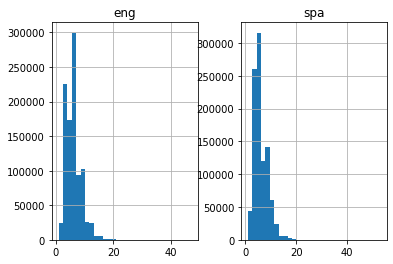

In [20]:
length_df.hist(bins = 30)
plt.show()

La máxima longitud de las frasese en inglés es 47 y de las frases en español es 53.

Se vectoriza el texto usando la clase de tokenizador de Keras, la cual convierte las frases en secuencias de enteros. Después algunas de esas frases se rellenan con ceros hasta alcanzar la longitud máxima, de tal forma que todas las frases posean la misma longitud.


In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [50]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('Tamaño del vocabulario inglés: %d' % eng_vocab_size)

Tamaño del vocabulario inglés: 13731


In [51]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Tamaño del vocabulario español: %d' % spa_vocab_size)

Tamaño del vocabulario español: 27431


In [24]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 1832), ('vete', 312), ('vaya', 1360), ('váyase', 64), ('hola', 176), ('¡corre', 8), ('¡corran', 8), ('¡corra', 8), ('¡corred', 8), ('corred', 24), ('¿quién', 4856), ('¡órale', 80), ('¡fuego', 32), ('¡incendio', 8), ('¡disparad', 24), ('¡ayuda', 16), ('¡socorro', 8), ('¡auxilio', 16), ('¡salta', 8), ('salte', 24), ('¡parad', 8), ('¡para', 32), ('¡pare', 8), ('¡espera', 32), ('esperen', 96), ('continúa', 160), ('continúe', 64), ('corrí', 152), ('corría', 88), ('lo', 55368), ('intento', 272), ('¡he', 16), ('ganado', 304), ('¡oh', 72), ('no', 164504), ('tomátelo', 16), ('con', 39392), ('soda', 32), ('¡disparen', 8), ('¡dispara', 8), ('¡dispará', 8), ('¡dispare', 8), ('sonríe', 96), ('¡al', 24), ('ataque', 208), ('¡atacad', 8), ('¡ataque', 8), ('¡ataquen', 8), ('¡ataca', 8), ('levanta', 336), ('ahora', 8704), ('mismo', 4488), ('id', 56), ('vayan', 192), ('ya', 8496), ('¡lo', 80), ('tengo', 17032), ('¿lo', 672), ('pillas', 16), ('¿entendiste', 80), ('él', 55944), ('corrió

La siguiente función prepara las frases de la forma que se ha especificado anteriormente.


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

## Primer modelo
Cabe destacar que, este modelo posee la misma estructura que utilizaba el modelo que realiza la tradución de inglés a alemán. 

Sin embargo, en este caso se ha hecho uso de todas las frases existentes en el fichero de datos inicial, mientras que en el otro modelo se hizo una selección de únicamente las primeras 50000 frases.


### Preparar conjuntos entrenamiento y test

En primer lugar se separan los datos en conjunto de entrenamiento y conjunto de test para entrenar y evaluar el modelo.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

A continuación, se codifican las frases. Se codifican las frases en español como las entradas al modelo y las frases en inglés como las secuencias objetivo/meta del modelo. De esta forma se está creando un traductor de español a inglés.

Este proceso se realiza tanto para el conjunto de entrenamiento como el de test.


In [54]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[  19  243  576 ...    6  361    0]
 [4771   90    8 ...    0    0    0]
 [  17 1354 2673 ...   25 7668    0]
 ...
 [  23    4   22 ... 1032   30 1302]
 [  51    7  188 ... 1027    0    0]
 [   7 5665   11 ...    0    0    0]]
885139
[[  17  166  292 ...  373    0    0]
 [  73    4  741 ...    9  214    0]
 [   1 1211  221 ...    3  858    0]
 ...
 [  21   56   35 ...   37  197    0]
 [ 147  153   42 ...    0    0    0]
 [   1  166  255 ...    3   16    0]]
885139


In [28]:
print(trainX.shape)
print(trainY.shape)

(786790, 8)
(786790, 8)


In [55]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  23   74 1146 ...    0    0    0]
 [   6  607   21 ...    0    0    0]
 [3807 2611    0 ...    0    0    0]
 ...
 [   4 1017  172 ...    0    0    0]
 [ 290  961   66 ...    0    0    0]
 [ 908    7  728 ...    0    0    0]]
221285
[[ 21 981  92 ...   0   0   0]
 [  1 364   7 ...   0   0   0]
 [  4  22 436 ...   0   0   0]
 ...
 [  2  56  82 ...  11 143 228]
 [ 22   4 396 ...   0   0   0]
 [ 22   4 140 ...   0   0   0]]
221285


In [30]:
print(testX.shape)
print(testY.shape)

(196698, 8)
(196698, 8)


### Construir y entrenar el modelo

Para construir la arquitectura Seq2Seq se necesitan dos partes: por un lado el codificador, que en este caso estará compuesto de una capa de embedding y una capa LSTM y, por otro lado, el decodifcador que está formado por una capa LSTM y una capa densamente conectada.

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

La capa de *RepeatVector* tiene la función de añadir una dimensión extra al dataset, con el fin de que se adapte a la siguiente capa del modelo que necesita una tercera dimensión   (https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6).

Se utiliza el optimizador RMSprop en este modelo ya que normalmente es una buena elección para redes neuronales recurrentes (RNN).

In [30]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

27431
13731
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Se hace uso de **'sparse_categorical_crossentropy'** como la función de pérdida ya que permite usa la secuencia meta tal cual se le pasa al modelo, en lugar de tener que usar codificación one hot, la cual ocuparía un gran espacio de memoria con un vocabulario de la magnitud tan elevada como el que se está empleando.

Ahora se procede al entrenamiento de modelo durante 30 épocas con un tamaño de batch de 512. También se usa la función **ModelCheckpoint()** para guardar el mejor modelo con la menor pérdida en validación, o lo que es lo mismo, la mayor precisión sobre el conjunto de test.


In [32]:
filename = 'model.h1.26_apr_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 550752 samples, validate on 137689 samples
Epoch 1/30
550752/550752 [==============================] - 403s 732us/step - loss: 3.9949 - accuracy: 0.3763 - val_loss: 3.0502 - val_accuracy: 0.4672

Epoch 00001: val_loss improved from inf to 3.05020, saving model to model.h1.26_apr_20
Epoch 2/30
550752/550752 [==============================] - 401s 729us/step - loss: 2.4434 - accuracy: 0.5377 - val_loss: 2.0032 - val_accuracy: 0.5975

Epoch 00002: val_loss improved from 3.05020 to 2.00317, saving model to model.h1.26_apr_20
Epoch 3/30
550752/550752 [==============================] - 402s 729us/step - loss: 1.6713 - accuracy: 0.6487 - val_loss: 1.4855 - val_accuracy: 0.6824

Epoch 00003: val_loss improved from 2.00317 to 1.48549, saving model to model.h1.26_apr_20
Epoch 4/30
550752/550752 [==============================] - 401s 728us/step - loss: 1.2001 - accuracy: 0.7375 - val_loss: 1.1250 - val_accuracy: 0.7550

Epoch 00004: val_loss improved from 1.48549 to 1.12504, saving mode

Cabe destacar que el modelo anterior emplea aproximadamente 6 minutos para realizar cada epoch, lo cual es un tiempo bastante elevado y a tener en cuenta para el entrenamiento de los modelos posteriores.

Simplemente observando la salida obtenida del entrenamiento del modelo puede apreciarse que los resultados obtenidos de precisión son muy elevados y los de pérdida bastante bajos, como es deseable. A continuación se muestran las salidas dadas por cada época del modelo de tal forma que pueda observase su evoución sin tener que volver a ejecutar la celda de entrenamiento, en el caso de que se pierda la salida:

```
Train on 550752 samples, validate on 137689 samples
Epoch 1/30
550752/550752 [==============================] - 403s 732us/step - loss: 3.9949 - accuracy: 0.3763 - val_loss: 3.0502 - val_accuracy: 0.4672

Epoch 00001: val_loss improved from inf to 3.05020, saving model to model.h1.26_apr_20
Epoch 2/30
550752/550752 [==============================] - 401s 729us/step - loss: 2.4434 - accuracy: 0.5377 - val_loss: 2.0032 - val_accuracy: 0.5975

Epoch 00002: val_loss improved from 3.05020 to 2.00317, saving model to model.h1.26_apr_20
Epoch 3/30
550752/550752 [==============================] - 402s 729us/step - loss: 1.6713 - accuracy: 0.6487 - val_loss: 1.4855 - val_accuracy: 0.6824

Epoch 00003: val_loss improved from 2.00317 to 1.48549, saving model to model.h1.26_apr_20
Epoch 4/30
550752/550752 [==============================] - 401s 728us/step - loss: 1.2001 - accuracy: 0.7375 - val_loss: 1.1250 - val_accuracy: 0.7550

Epoch 00004: val_loss improved from 1.48549 to 1.12504, saving model to model.h1.26_apr_20
Epoch 5/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.8664 - accuracy: 0.8086 - val_loss: 0.8464 - val_accuracy: 0.8164

Epoch 00005: val_loss improved from 1.12504 to 0.84641, saving model to model.h1.26_apr_20
Epoch 6/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.6267 - accuracy: 0.8621 - val_loss: 0.6756 - val_accuracy: 0.8518

Epoch 00006: val_loss improved from 0.84641 to 0.67564, saving model to model.h1.26_apr_20
Epoch 7/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.4613 - accuracy: 0.9002 - val_loss: 0.5098 - val_accuracy: 0.8911

Epoch 00007: val_loss improved from 0.67564 to 0.50977, saving model to model.h1.26_apr_20
Epoch 8/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.3470 - accuracy: 0.9254 - val_loss: 0.4021 - val_accuracy: 0.9142

Epoch 00008: val_loss improved from 0.50977 to 0.40213, saving model to model.h1.26_apr_20
Epoch 9/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.2675 - accuracy: 0.9427 - val_loss: 0.3223 - val_accuracy: 0.9312

Epoch 00009: val_loss improved from 0.40213 to 0.32233, saving model to model.h1.26_apr_20
Epoch 10/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.2141 - accuracy: 0.9539 - val_loss: 0.2682 - val_accuracy: 0.9428

Epoch 00010: val_loss improved from 0.32233 to 0.26821, saving model to model.h1.26_apr_20
Epoch 11/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.1765 - accuracy: 0.9612 - val_loss: 0.2259 - val_accuracy: 0.9508

Epoch 00011: val_loss improved from 0.26821 to 0.22590, saving model to model.h1.26_apr_20
Epoch 12/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.1502 - accuracy: 0.9661 - val_loss: 0.1949 - val_accuracy: 0.9573

Epoch 00012: val_loss improved from 0.22590 to 0.19487, saving model to model.h1.26_apr_20
Epoch 13/30
550752/550752 [==============================] - 400s 727us/step - loss: 0.1313 - accuracy: 0.9694 - val_loss: 0.1715 - val_accuracy: 0.9614

Epoch 00013: val_loss improved from 0.19487 to 0.17152, saving model to model.h1.26_apr_20
Epoch 14/30
550752/550752 [==============================] - 401s 727us/step - loss: 0.1179 - accuracy: 0.9716 - val_loss: 0.1546 - val_accuracy: 0.9642

Epoch 00014: val_loss improved from 0.17152 to 0.15465, saving model to model.h1.26_apr_20
Epoch 15/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.1077 - accuracy: 0.9732 - val_loss: 0.1416 - val_accuracy: 0.9670

Epoch 00015: val_loss improved from 0.15465 to 0.14156, saving model to model.h1.26_apr_20
Epoch 16/30
550752/550752 [==============================] - 400s 727us/step - loss: 0.1003 - accuracy: 0.9743 - val_loss: 0.1316 - val_accuracy: 0.9684

Epoch 00016: val_loss improved from 0.14156 to 0.13157, saving model to model.h1.26_apr_20
Epoch 17/30
550752/550752 [==============================] - 400s 727us/step - loss: 0.0945 - accuracy: 0.9752 - val_loss: 0.1226 - val_accuracy: 0.9699

Epoch 00017: val_loss improved from 0.13157 to 0.12263, saving model to model.h1.26_apr_20
Epoch 18/30
550752/550752 [==============================] - 401s 727us/step - loss: 0.0901 - accuracy: 0.9758 - val_loss: 0.1173 - val_accuracy: 0.9707

Epoch 00018: val_loss improved from 0.12263 to 0.11729, saving model to model.h1.26_apr_20
Epoch 19/30
550752/550752 [==============================] - 401s 728us/step - loss: 0.0865 - accuracy: 0.9763 - val_loss: 0.1126 - val_accuracy: 0.9718

Epoch 00019: val_loss improved from 0.11729 to 0.11258, saving model to model.h1.26_apr_20
Epoch 20/30
550752/550752 [==============================] - 401s 729us/step - loss: 0.0839 - accuracy: 0.9766 - val_loss: 0.1078 - val_accuracy: 0.9722

Epoch 00020: val_loss improved from 0.11258 to 0.10780, saving model to model.h1.26_apr_20
Epoch 21/30
550752/550752 [==============================] - 399s 725us/step - loss: 0.0814 - accuracy: 0.9769 - val_loss: 0.1035 - val_accuracy: 0.9732

Epoch 00021: val_loss improved from 0.10780 to 0.10353, saving model to model.h1.26_apr_20
Epoch 22/30
550752/550752 [==============================] - 399s 725us/step - loss: 0.0796 - accuracy: 0.9771 - val_loss: 0.1010 - val_accuracy: 0.9735

Epoch 00022: val_loss improved from 0.10353 to 0.10097, saving model to model.h1.26_apr_20
Epoch 23/30
550752/550752 [==============================] - 400s 727us/step - loss: 0.0779 - accuracy: 0.9773 - val_loss: 0.0973 - val_accuracy: 0.9740

Epoch 00023: val_loss improved from 0.10097 to 0.09729, saving model to model.h1.26_apr_20
Epoch 24/30
550752/550752 [==============================] - 400s 727us/step - loss: 0.0763 - accuracy: 0.9776 - val_loss: 0.0955 - val_accuracy: 0.9743

Epoch 00024: val_loss improved from 0.09729 to 0.09555, saving model to model.h1.26_apr_20
Epoch 25/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0753 - accuracy: 0.9776 - val_loss: 0.0935 - val_accuracy: 0.9748

Epoch 00025: val_loss improved from 0.09555 to 0.09351, saving model to model.h1.26_apr_20
Epoch 26/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0740 - accuracy: 0.9778 - val_loss: 0.0930 - val_accuracy: 0.9748

Epoch 00026: val_loss improved from 0.09351 to 0.09299, saving model to model.h1.26_apr_20
Epoch 27/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0728 - accuracy: 0.9780 - val_loss: 0.0914 - val_accuracy: 0.9749

Epoch 00027: val_loss improved from 0.09299 to 0.09142, saving model to model.h1.26_apr_20
Epoch 28/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0720 - accuracy: 0.9780 - val_loss: 0.0898 - val_accuracy: 0.9749

Epoch 00028: val_loss improved from 0.09142 to 0.08981, saving model to model.h1.26_apr_20
Epoch 29/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0711 - accuracy: 0.9781 - val_loss: 0.0893 - val_accuracy: 0.9753

Epoch 00029: val_loss improved from 0.08981 to 0.08927, saving model to model.h1.26_apr_20
Epoch 30/30
550752/550752 [==============================] - 400s 726us/step - loss: 0.0704 - accuracy: 0.9781 - val_loss: 0.0872 - val_accuracy: 0.9754

```





Tal y como se puede observar en la salida, el modelo consigue al canzar una precisión por encima del 97% y con pérdidas inferiores a 0.08.

En la siguiente tabla se muestra su arquitectura más en detalle. Puede apreciarse que el modelo es bastante complejo puesto que consta de 25 millones de parámetros para entrenar.


In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            14044672  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 13731)          7044003   
Total params: 25,287,075
Trainable params: 25,287,075
Non-trainable params: 0
_________________________________________________________________



Se representa y se compara tanto la presisión como la pérdida obtenida en entrenamiento y test de tal forma que pueda apreciarse su evolución de manera visual.

Como ya ha podido comprobarse con los resultados numéricos de la salida del entrenamiento, el modelo alcanza unos niveles de precisión muy elevados, en torno a 0.97 y unos niveles de pérdidas muy bajos, por debajo de 0.1. Además, las forma de las curvas es la deseable puesto que a medida que aumenta el número de épocas, el modelo va mejorando sus resultados. Tanto las curvas de entrenamiento como las de validación se encuentran muy próximas.

Cabe destacar que a partir de la época 15 el modelo no consigue mejorar sus resultados de manera significativa, es por ello que en el segundo modelo se va a realizar el entrenamiento con 15 épocas. Además, de esta forma se reduce considerablemente el tiempo de ejecución.

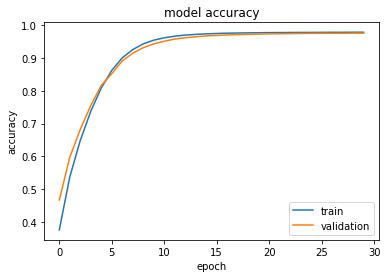

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

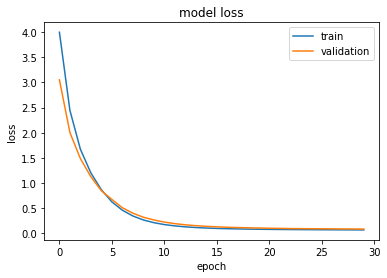

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

### Hacer predicciones


Se carga el modelo guardado y se ejecutan algunas predicciones para comprobar qué tal se ralizan las traducciones de español a inglés, además de comprobar si las frases predichas con el modelo en inglés se corresponden con las reales.

Cabe destacar que tan solo se van a hacer predicciones para las 50000 primeras frases ya que no se dispone de memoria RAM suficiente para cargar el conjunto de datos completo además del modelo.

In [20]:
model = load_model('model.h1.26_apr_20')
preds = model.predict_classes(testX[:50000,:].reshape((testX[:50000,:].shape[0],testX[:50000,:].shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [35]:
len(preds_text)


50000

In [0]:
pred_df = pd.DataFrame({'actual' : test[:50000,1], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

Si se muestran las parejas de frases reales-frases predichas por el modelo, se puede observar que el traductor automático es bastante potente, obteniendo las mismas salidas salvo para la fras número 3 en la que se produce un error puesto que omite el sujeto.

In [54]:
pred_df.head(15)

,actual,predicted
0,were in no hurry,were in no hurry
1,i lost the watch that my father gave me,lost the watch that my father gave me
2,i was happy then,i was happy then
3,i regarded him as the best doctor in town,regarded him as the best doctor in town
4,could you help me with that,could you help me with that
5,can anybody else answer,can anybody else answer
6,we may not win tomorrow,we may not win tomorrow
7,she called me many terrible things,she called me many terrible things
8,mary is interested in politics,mary is interested in politics
9,how did you get this money,how did you get by this money


Similar ocurre con la siguiente muestra de las últimas frases, el modelo consigue una traducción perfecta.

In [55]:
pred_df.tail(15)

,actual,predicted
49985,that worked well,that worked well
49986,i found the new magazine very interesting,i found the new magazine very interesting
49987,i made it myself,i made it myself
49988,this is not my specialty,this is not my specialty
49989,i thought you werent interested in politics,i thought you werent interested in politics
49990,where are your sons toys,where are your sons toys
49991,we have only one chance,we have only one chance
49992,could you do me a favor,could you do me a favor
49993,it happened while i wasnt looking,it happened while i wasnt looking
49994,can i eat this,may i eat this


Ahora, se ejecuta la tradución de 15 muestras aleatorias del texto. Puede observarse que en la muestra 45418 el modelo comete un error de traducción, traduciendo una orden como una sugerencia. Salvo esto, el resto de traducciones son correctas.

In [56]:
pred_df.sample(15)

,actual,predicted
23926,i want to see him,i want to see it
44004,well girls its time to go,well girls its time to go
14518,check around,check around
10860,come this way,come this way
4182,theres only one way to find out,theres only one way to find out
29304,thats what tom said,thats what tom said
23042,what tom really wanted was enough money to buy a house,wanted was enough money to buy a house
47593,get used to it tom,get used to it tom
48890,tom isnt able to drive yet,tom isnt able to drive yet
34966,it seems hes still alive,it seems hes still alive


Finalmente, para que puedda apreciarse de una manera más clara, se muestran una serie de frases en español con su traducción en inglés calculada por el modelo.

En general, todas las traducciones son correctas salvo en la frase 12549 que el modelo no es capaz de traducir una frase hecha española como es "fue tonto de mi parte", la cual es sustituida directamente por el pronombre *me*. Igualmente en la frase 32159, la locución "tratar de" en inglés podría traducirse como *try to* pero el modelo omite el verbo *try*.

Es por estos pequeños errores por los que la precisión no alcanza el 99% pero, como puede observarse, el modelo generado es muy potente.

In [0]:
pred_df_spa = pd.DataFrame({'actual' : test[:50000,1], 'predicted' : preds_text})

In [60]:
pred_df_spa.sample(15)

,actual,predicted
29027,el presidente johnson rechazó el acuerdo,president johnson rejected the agreement
44316,este perro muerde,this dog bites
17477,los niños necesitan jugar,children need to play
29565,tienes que responder a esta carta,you have to reply to the letter
12874,dale un beso a tom,give tom a kiss
12549,fue tonto de mi parte haber cometido dos veces el mismo error,me to have made the same mistake twice
48380,al final se tuvieron que reconocer sus derechos,eventually his rights had to be acknowledged
36450,averigua más sobre tom,find out more about tom
12627,¿dónde está tu madre,wheres your mother
26586,tom estaba llorando,tom was crying


## Segundo modelo

Con el primer modelo se obtenían unos resultados de precisión muy elevados pero su entrenamiento implicaba también un gran coste computacional, es por ello que ahora se va a implementar un modelo más sencillo. De esta manera se pretende comprobar si con un modelo de menor complejidad pueden alcanzarse resultados aceptables de precisión. Se intenta alcanzar un equilibrio en el compromiso complejidad-precisión.


### Construir y entrenar el modelo

Con el fin de lograr lo especificado anteriormente la arquitectura anterior sequence-to-sequence se va a sustituir por un RNN simple. De tal forma que ahora el modelo cuenta con una capa de Embedding, una SimpleRNN, una capa de RepeatVector para adaptar la dimiensionalidad y una capa densamente conectada.

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    #model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    #model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
  
    return model

La siguiente tabla muestra con mayor detalle la arquitectura del modelo creado así como el número de parámetros total a entrenar. Se observa que, al contrario de lo que ocurría con el modelo anterior, en este caso el número de parámetros se ve reducido considerablemente, en torno a 1.7 millones.

In [26]:
model = build_model(spa_vocab_size, spa_vocab_size, spa_length, eng_length, 32)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 32)             877792    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 8, 32)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 8, 27431)          905223    
Total params: 1,785,095
Trainable params: 1,785,095
Non-trainable params: 0
_________________________________________________________________


In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Se van a modificar algunos hipérparámetros del modelo como son el número de epochs, reduciéndolo a la mitad y el tamaño del batch, igualándolo a 1024.

In [29]:
filename = 'model.h1.27_apr_20_m2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=1024, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 629432 samples, validate on 157358 samples
Epoch 1/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.3793 - accuracy: 0.2683 - val_loss: 5.3600 - val_accuracy: 0.2680

Epoch 00001: val_loss improved from inf to 5.35998, saving model to model.h1.27_apr_20_m2
Epoch 2/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.3121 - accuracy: 0.2683 - val_loss: 5.2804 - val_accuracy: 0.2680

Epoch 00002: val_loss improved from 5.35998 to 5.28039, saving model to model.h1.27_apr_20_m2
Epoch 3/15
629432/629432 [==============================] - 401s 636us/step - loss: 5.2729 - accuracy: 0.2683 - val_loss: 5.2740 - val_accuracy: 0.2680

Epoch 00003: val_loss improved from 5.28039 to 5.27397, saving model to model.h1.27_apr_20_m2
Epoch 4/15
629432/629432 [==============================] - 400s 636us/step - loss: 5.2706 - accuracy: 0.2683 - val_loss: 5.2735 - val_accuracy: 0.2680

Epoch 00004: val_loss improved from 5.27397 to 5.27349, sa

La salida obtenida tras el entrenamiento del segundo modelo se muestra a continuación y en ella puede observarse que en este caso los niveles de precisión alcanzados rondan el 26% mientras que las pérdidas son aproximadamente de 5.2:

```
Train on 629432 samples, validate on 157358 samples
Epoch 1/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.3793 - accuracy: 0.2683 - val_loss: 5.3600 - val_accuracy: 0.2680

Epoch 00001: val_loss improved from inf to 5.35998, saving model to model.h1.27_apr_20_m2
Epoch 2/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.3121 - accuracy: 0.2683 - val_loss: 5.2804 - val_accuracy: 0.2680

Epoch 00002: val_loss improved from 5.35998 to 5.28039, saving model to model.h1.27_apr_20_m2
Epoch 3/15
629432/629432 [==============================] - 401s 636us/step - loss: 5.2729 - accuracy: 0.2683 - val_loss: 5.2740 - val_accuracy: 0.2680

Epoch 00003: val_loss improved from 5.28039 to 5.27397, saving model to model.h1.27_apr_20_m2
Epoch 4/15
629432/629432 [==============================] - 400s 636us/step - loss: 5.2706 - accuracy: 0.2683 - val_loss: 5.2735 - val_accuracy: 0.2680

Epoch 00004: val_loss improved from 5.27397 to 5.27349, saving model to model.h1.27_apr_20_m2
Epoch 5/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.2705 - accuracy: 0.2683 - val_loss: 5.2728 - val_accuracy: 0.2680

Epoch 00005: val_loss improved from 5.27349 to 5.27276, saving model to model.h1.27_apr_20_m2
Epoch 6/15
629432/629432 [==============================] - 401s 637us/step - loss: 5.2702 - accuracy: 0.2683 - val_loss: 5.2732 - val_accuracy: 0.2680

Epoch 00006: val_loss did not improve from 5.27276
Epoch 7/15
629432/629432 [==============================] - 400s 635us/step - loss: 5.2703 - accuracy: 0.2683 - val_loss: 5.2727 - val_accuracy: 0.2680

Epoch 00007: val_loss improved from 5.27276 to 5.27267, saving model to model.h1.27_apr_20_m2
Epoch 8/15
629432/629432 [==============================] - 400s 636us/step - loss: 5.2703 - accuracy: 0.2683 - val_loss: 5.2727 - val_accuracy: 0.2680

Epoch 00008: val_loss did not improve from 5.27267
Epoch 9/15
629432/629432 [==============================] - 400s 635us/step - loss: 5.2701 - accuracy: 0.2683 - val_loss: 5.2731 - val_accuracy: 0.2680

Epoch 00009: val_loss did not improve from 5.27267
Epoch 10/15
629432/629432 [==============================] - 400s 635us/step - loss: 5.2704 - accuracy: 0.2683 - val_loss: 5.2731 - val_accuracy: 0.2680

Epoch 00010: val_loss did not improve from 5.27267
Epoch 11/15
629432/629432 [==============================] - 399s 634us/step - loss: 5.2704 - accuracy: 0.2683 - val_loss: 5.2729 - val_accuracy: 0.2680

Epoch 00011: val_loss did not improve from 5.27267
Epoch 12/15
629432/629432 [==============================] - 400s 635us/step - loss: 5.2703 - accuracy: 0.2683 - val_loss: 5.2727 - val_accuracy: 0.2680

Epoch 00012: val_loss did not improve from 5.27267
Epoch 13/15
629432/629432 [==============================] - 400s 636us/step - loss: 5.2703 - accuracy: 0.2683 - val_loss: 5.2728 - val_accuracy: 0.2680

Epoch 00013: val_loss did not improve from 5.27267
Epoch 14/15
629432/629432 [==============================] - 399s 634us/step - loss: 5.2703 - accuracy: 0.2683 - val_loss: 5.2733 - val_accuracy: 0.2680

Epoch 00014: val_loss did not improve from 5.27267
Epoch 15/15
629432/629432 [==============================] - 399s 634us/step - loss: 5.2702 - accuracy: 0.2683 - val_loss: 5.2730 - val_accuracy: 0.2680

Epoch 00015: val_loss did not improve from 5.27267
```

Los resultados obtenidos con el segundo modelo son significativamente peores que los obtenidos por el primer modelo. De hecho, como puede observarse en las gráficas inferiores, el modelo no consigue incrementar su precisión con el paso de las distintas épocas. Esto puede deberse a que se queda atascado en un mínimo local del que no es capaz de salir.

Las pérdidas disminuyen con el paso de las épocas pero no de manera considerable, tan solo consiguen bajar un 0.1 tras 15 épocas.

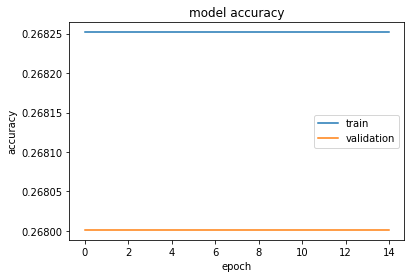

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

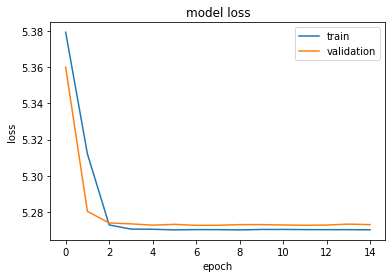

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

### Hacer predicciones

Se van a realizar las mismas predicciones que con el primer modelo, solo que en este caso se va a truncar a las 20000 primeras frases (igualmente por problemas de RAM), de tal forma que puedan compararse los resultados obtenidos por ambas arquitecturas.

In [21]:
model = load_model('model.h1.27_apr_20_m2')
preds = model.predict_classes(testX[:20000,:].reshape((testX[:20000,:].shape[0],testX[:20000,:].shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [32]:
len(preds_text)

20000

In [0]:
pred_df = pd.DataFrame({'actual' : test[:20000,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

De hecho, el modelo, al poseer una precisión tan baja, muy por debajo del 50%, no consigue realizar las predicciones y devuelve un vector vacío.

In [26]:
pred_df.head(15)

,actual,predicted
0,she taught us singing,
1,the dinner is almost ready,
2,you are under arrest,
3,if you flunk this exam youll have to repeat the course,
4,are you freezing,
5,boston is my home,
6,tom is stupider than you think,
7,i need to know whats happening,
8,tom only eats lean meats and vegetables,
9,i had things to take care of,


Lo ocurrido con la arquitectura del segundo modelo sirve para constatar lo estudiado durante las clases téoricas: el modelo SimpleRNN es demasiado simplista para que sea de utilidad. Aunque en teoría debería ser capaz de retener la información del texto durante un cierto periodo de tiempo, en la práctica las dependencias a largo plazo resultan imposibles de aprender para una red neuronal recurrente simple.

Esto se debe al problema de desvanecimiento del gradiente, que se da cuando el gradiente va disminuyendo a valores muy pequeños, impidiendo a los pesos de la red cambiar eficazmente su valor. En el peor de los casos, el problema impide que la red neuronal continúe su entrenamiento. Esto es lo que ha ocurrido en la presente práctica con el segundo modelo, ya que el entrenamiento no ha avanzado sino que se ha quedado estancado en un punto de precisión 0.2 y pérdidas en torno a un valor de 5.


## Tercer modelo
En el tercer y último modelo se va a hacer uso de una arquitectura que emplea capas GRU en lugar de capas LSTM. Precisamente, con el objetivo de eliminar el problema del descenso del gradiente, aparecen las capas recurrentes tipo LSTM y GRU. 

Las arquitectura con LSTM ya se he implementado en el primer modelo y se han observado sus buenos resultados. A continuación se construye un modelo con capas GRU a fin de poder comparar su eficacia.

### Construir y entrenar el modelo

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    #o comentar esta última línea
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
  
    return model

In [22]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 64)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 64)             1755584   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24768     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 64)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 8, 64)             24768     
_________________________________________________________________
dense_1 (Dense)              (None, 8, 13731)          892515    
Total params: 2,697,635
Trainable params: 2,697,635
Non-trainable params: 0
_________________________________________________________________


El modelo se entrena durante 15 épocas puesto que, como se pudo observar con el primer modelo, es el punto medio entre complejidad y precisión. El tamaño de batch es igual a 512 y similar al empleado en el modelo 1 de tal forma que los resultados de ambos sean comparables.

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
filename = 'model.h1.27_apr_20_m3'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 708111 samples, validate on 177028 samples
Epoch 1/15
708111/708111 [==============================] - 306s 431us/step - loss: 4.7263 - accuracy: 0.3100 - val_loss: 4.3511 - val_accuracy: 0.3339

Epoch 00001: val_loss improved from inf to 4.35110, saving model to model.h1.27_apr_20_m3
Epoch 2/15
708111/708111 [==============================] - 303s 427us/step - loss: 4.0879 - accuracy: 0.3644 - val_loss: 3.8704 - val_accuracy: 0.3835

Epoch 00002: val_loss improved from 4.35110 to 3.87036, saving model to model.h1.27_apr_20_m3
Epoch 3/15
708111/708111 [==============================] - 303s 427us/step - loss: 3.5905 - accuracy: 0.4104 - val_loss: 3.4127 - val_accuracy: 0.4262

Epoch 00003: val_loss improved from 3.87036 to 3.41271, saving model to model.h1.27_apr_20_m3
Epoch 4/15
708111/708111 [==============================] - 303s 428us/step - loss: 3.2043 - accuracy: 0.4502 - val_loss: 3.0854 - val_accuracy: 0.4635

Epoch 00004: val_loss improved from 3.41271 to 3.08536, sa

La salida obtenida tras el entrenamiento del modelo se muestra a continuación y en ella puede observarse que en este caso los niveles de precisión alcanzados rondan el 66% mientra que las pérdidas son aproximadamente de 1.8:

```
Train on 708111 samples, validate on 177028 samples
Epoch 1/15
708111/708111 [==============================] - 306s 431us/step - loss: 4.7263 - accuracy: 0.3100 - val_loss: 4.3511 - val_accuracy: 0.3339

Epoch 00001: val_loss improved from inf to 4.35110, saving model to model.h1.27_apr_20_m3
Epoch 2/15
708111/708111 [==============================] - 303s 427us/step - loss: 4.0879 - accuracy: 0.3644 - val_loss: 3.8704 - val_accuracy: 0.3835

Epoch 00002: val_loss improved from 4.35110 to 3.87036, saving model to model.h1.27_apr_20_m3
Epoch 3/15
708111/708111 [==============================] - 303s 427us/step - loss: 3.5905 - accuracy: 0.4104 - val_loss: 3.4127 - val_accuracy: 0.4262

Epoch 00003: val_loss improved from 3.87036 to 3.41271, saving model to model.h1.27_apr_20_m3
Epoch 4/15
708111/708111 [==============================] - 303s 428us/step - loss: 3.2043 - accuracy: 0.4502 - val_loss: 3.0854 - val_accuracy: 0.4635

Epoch 00004: val_loss improved from 3.41271 to 3.08536, saving model to model.h1.27_apr_20_m3
Epoch 5/15
708111/708111 [==============================] - 302s 427us/step - loss: 2.9001 - accuracy: 0.4857 - val_loss: 2.8341 - val_accuracy: 0.4930

Epoch 00005: val_loss improved from 3.08536 to 2.83411, saving model to model.h1.27_apr_20_m3
Epoch 6/15
708111/708111 [==============================] - 302s 426us/step - loss: 2.6576 - accuracy: 0.5165 - val_loss: 2.6093 - val_accuracy: 0.5223

Epoch 00006: val_loss improved from 2.83411 to 2.60927, saving model to model.h1.27_apr_20_m3
Epoch 7/15
708111/708111 [==============================] - 302s 427us/step - loss: 2.4684 - accuracy: 0.5426 - val_loss: 2.4520 - val_accuracy: 0.5446

Epoch 00007: val_loss improved from 2.60927 to 2.45204, saving model to model.h1.27_apr_20_m3
Epoch 8/15
708111/708111 [==============================] - 302s 426us/step - loss: 2.3156 - accuracy: 0.5651 - val_loss: 2.3217 - val_accuracy: 0.5636

Epoch 00008: val_loss improved from 2.45204 to 2.32168, saving model to model.h1.27_apr_20_m3
Epoch 9/15
708111/708111 [==============================] - 302s 426us/step - loss: 2.1913 - accuracy: 0.5840 - val_loss: 2.2335 - val_accuracy: 0.5755

Epoch 00009: val_loss improved from 2.32168 to 2.23354, saving model to model.h1.27_apr_20_m3
Epoch 10/15
708111/708111 [==============================] - 302s 426us/step - loss: 2.0885 - accuracy: 0.6004 - val_loss: 2.1717 - val_accuracy: 0.5830

Epoch 00010: val_loss improved from 2.23354 to 2.17169, saving model to model.h1.27_apr_20_m3
Epoch 11/15
708111/708111 [==============================] - 302s 427us/step - loss: 2.0017 - accuracy: 0.6143 - val_loss: 2.0507 - val_accuracy: 0.6055

Epoch 00011: val_loss improved from 2.17169 to 2.05069, saving model to model.h1.27_apr_20_m3
Epoch 12/15
708111/708111 [==============================] - 302s 427us/step - loss: 1.9282 - accuracy: 0.6267 - val_loss: 1.9944 - val_accuracy: 0.6144

Epoch 00012: val_loss improved from 2.05069 to 1.99440, saving model to model.h1.27_apr_20_m3
Epoch 13/15
708111/708111 [==============================] - 303s 427us/step - loss: 1.8651 - accuracy: 0.6376 - val_loss: 1.9863 - val_accuracy: 0.6144

Epoch 00013: val_loss improved from 1.99440 to 1.98628, saving model to model.h1.27_apr_20_m3
Epoch 14/15
708111/708111 [==============================] - 302s 427us/step - loss: 1.8096 - accuracy: 0.6473 - val_loss: 1.9187 - val_accuracy: 0.6248

Epoch 00014: val_loss improved from 1.98628 to 1.91871, saving model to model.h1.27_apr_20_m3
Epoch 15/15
708111/708111 [==============================] - 302s 427us/step - loss: 1.7609 - accuracy: 0.6559 - val_loss: 1.8405 - val_accuracy: 0.6415
```

El primer modelo, en la epoch número 15 ya consigue alcanzar una precisión del 97% mientras que el tercer modelo se queda en el 64% con lo que puede decirse que el tercer modelo obtiene buenos resultados pero no es tan eficiente como el primero, ya que, a igualdad de epócas, el primero obtiene mejores resultados.

En las gráficas que muestran la evolución de la precisión y de las pérdidas puede apreciarse que las curvas comienzan a estabilizarse a partir de la época 15. Se podría aumentar el número de épocas pero por la tendencia parece que el aumento de la precisión y la disminución de las pérdidas no vayan a ser demasiado significativas, al menos no para alcanzar los niveles del modelo uno.

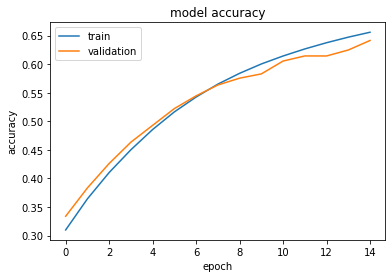

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

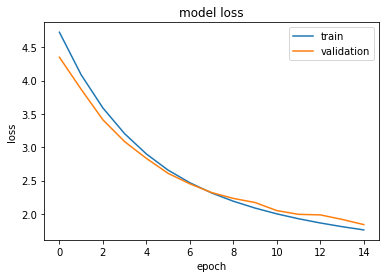

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

### Hacer predicciones

Al igual que se ha hecho con los modelos anteriores, se realizan las predicciones para un conjunto de frases iniciales del dataset.

In [56]:
model = load_model('model.h1.27_apr_20_m3')
preds = model.predict_classes(testX[:50000,:].reshape((testX[:50000,:].shape[0],testX[:50000,:].shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:50000,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

Como puede deducirse de los niveles de precisión alcanzados, las traducciones no se realizan con tan exactitud como ocurría con el modelo uno. El traductor encuentra dificultades sobre todo con ciertas palabras de vocabulario. Para cada frase, consigue traducir bien la mayoría de las palabras salvo algún verbo o nombres que intercambia por otros u omite.

La precisión alcanzada es elevada, pero no demasiado.

In [69]:
pred_df.head(15)

,actual,predicted
0,she taught us singing,she wanted to sing
1,the dinner is almost ready,father is almost ready
2,you are under arrest,you are arrested arrest
3,if you flunk this exam youll have to repeat the course,the youll to be the this
4,are you freezing,are you clean
5,boston is my home,my is my house
6,tom is stupider than you think,tom is what think you think
7,i need to know whats happening,i need to know what it
8,tom only eats lean meats and vegetables,tom just eats vegetables and
9,i had things to take care of,i just mind to care of


Similar ocurre con esta otra muestra de predicciones.

In [70]:
pred_df.tail(15)

,actual,predicted
49985,i cant forget tom,i cant forget tom
49986,tom says that hes never tried eating dog food,never to feed the food
49987,driving through that snowstorm was a nightmare,a of the building was a meeting
49988,thats true too,that is too
49989,eating with you is a pleasure,a is a to with you
49990,where did you learn that,where did you learn that
49991,my sister likes melons and so do i,he mother the when i
49992,ill look up the location of the town on my map,the in the map
49993,youd better not go,i better he go
49994,tom arrived the day mary left,tom left the day time he


Cuando se hacen las traducciones para 15 frases aleatorias se obtiene algo similar a los casos anteriores. Además, destaca el hecho de que el traductor posee mayor dificultad para traducir frases largas y complejas que frases más cortas, como es el caso de la frase 39313 y la 30814.

In [71]:
pred_df.sample(15)

,actual,predicted
35191,i have something to give to you,i have something to you
13747,mary looks pretty today,tom is very
44029,she allegedly murdered him,she murdered killed him
41676,he is usually straightforward and sincere and thereby gains the confidence of those who meet him,a many words that word who do trust
39313,even now i occasionally think id like to see you not the you that you are today but the you i remember from the past,i dont i you i you
18970,he wrote a book on china,he wrote a book of the china
45764,dont just read books go outside once in a while and get some exercise,i and long something some exercise
37575,you may return,you may return
28262,everyone is carrying an umbrella,no have their here
17763,four hundred fifty black pilots were in the group,there many were in the group


A continuación se muestran las traducciones en inglés de muestras aleatorias junto con la frase en español, de manera que pueda apreciarse con mayor claridad el trabajo realizado por el algoritmo.

In [0]:
pred_df_spa = pd.DataFrame({'actual' : test[:50000,1], 'predicted' : preds_text})

In [66]:
pred_df_spa.sample(15)

,actual,predicted
3955,estamos trabajando para reparar ese error,they it to this mistake
31338,te prestaré este libro,ill do you book
15886,es él ¿no,its is he
35680,él no es como nosotros,he isnt not with
13221,hablo tres idiomas,i speak three languages
18173,la tiré un puñetazo a la mandíbula,i saw him in the red
33291,él se sintió un poco culpable,he felt a felt guilty
35245,¿te vienes,are you coming
29929,solo quería hacerte unas pocas preguntas,i wanted to ask you a few questions
8996,ella le dijo que reescribiera su resumen,she told him to her his promised


Puede observarse que, a igual número de épocas, el primer algoritmo, haciendo uso de LSTM obtiene mejores resultados que el tercero, haciendo uso de GRU. Sin embargo, la tendencia de este último es buena, mejor que la de SimpleRNN, y podría iterarse sobre el mismo para mejorarlo. 

## Conclusión

Para concluir, cabe destacar que con esta práctica se ha hecho un barrido por las distintas arquitecturas existentes y que mejor se adaptan para el procesamiento de lenguaje natural. Así, se han probado modelos hacen uso tanto de capas LSTM como de RNN simples y de GRU.

La práctica ha sevido para afianzar los conceptos estudiados durante la teoría y comprobar de manera empírica cuáles son las arquitecturas de redes neuronales recurrentes más efectivas en el campo del procesamiento de lenguaje natural. 

Concretamente, se ha comprobado que las capas SimpleRNN obtienen los peores resultados y que, además, pueden caer con facilidad en el problema del desvanecimiento del gradiente. Con el fin de solucionar este problema existen las capas LSTM y GRU. Estas últimas obtienen buenos resultados, alcanando precisiones de en torno al 65% pero son sin duda las capas LSTM acompañadas de una arquitectura tipo *sequence to sequence* las que mejores resultados alcanzan para modelos de traducción automática, alcanzado una precisión del 97%. A igualdad de épocas, el primer modelo alcanza mejores resultados que los otros dos.